In [87]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json
import torch, tqdm, pickle
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json

In [88]:
with open('../data/split_keys.json') as fp:
    json_object = json.load(fp)

validation_tasks = json_object['val']

validation_tasks

['6150a2bd',
 'c8f0f002',
 '68b16354',
 'c9e6f938',
 '6fa7a44f',
 'ac0a08a4',
 '4258a5f9',
 '9ecd008a',
 '25ff71a9',
 '3af2c5a8',
 '67e8384a',
 '56ff96f3',
 'dc1df850',
 'ae4f1146',
 'aabf363d',
 'aedd82e4',
 '445eab21',
 '41e4d17e',
 'f5b8619d',
 '00d62c1b',
 '3906de3d',
 '8d5021e8',
 '0ca9ddb6',
 'd0f5fe59',
 'ba97ae07',
 'd9fac9be',
 'ded97339',
 'f8ff0b80',
 'dbc1a6ce',
 '496994bd',
 'fcb5c309',
 'ff805c23',
 '5c0a986e',
 '7f4411dc',
 '6d75e8bb',
 'e76a88a6',
 '8f2ea7aa',
 '137eaa0f',
 '6e82a1ae',
 'a5f85a15',
 '4be741c5',
 '681b3aeb',
 '3ac3eb23',
 '253bf280',
 '3428a4f5',
 'a9f96cdd',
 '1caeab9d',
 '3de23699',
 'bdad9b1f',
 '88a62173',
 'f8b3ba0a',
 '88a10436',
 '7e0986d6',
 'd4a91cb9',
 '913fb3ed',
 '3631a71a',
 '95990924',
 '93b581b8',
 '9edfc990',
 'a65b410d',
 'ef135b50',
 '6e19193c',
 'cbded52d',
 'ae3edfdc',
 '4612dd53',
 'e48d4e1a',
 '846bdb03',
 '2204b7a8',
 'e5062a87',
 '539a4f51',
 '91413438',
 'e8dc4411',
 'e40b9e2f',
 'd6ad076f',
 'b190f7f5',
 '6cdd2623',
 'f9012d9b',

In [89]:
from alphaarc.policy.tokenize import tokenize_task

def encode_task(task, tokenizer, model, input_state_max=256, n_examples=10, max_length=256): 
    tokenized_task = np.array(tokenize_task(task, tokenizer, n_examples, input_state_max, max_length)['input_ids'])
    return tokenized_task



In [ ]:
task = Task.from_json(f'../data/training/6fa7a44f.json')
model = T5ForConditionalGeneration.from_pretrained('../finetune/2025-05-27_17-42-37/checkpoint-1650')

task.program_lines

'x1 = hmirror(I)\nO = vconcat(I, x1)'

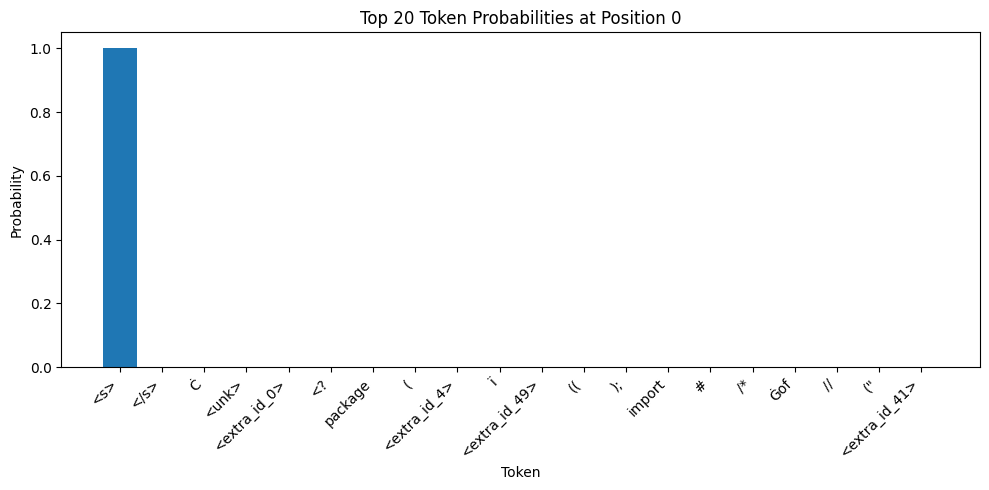

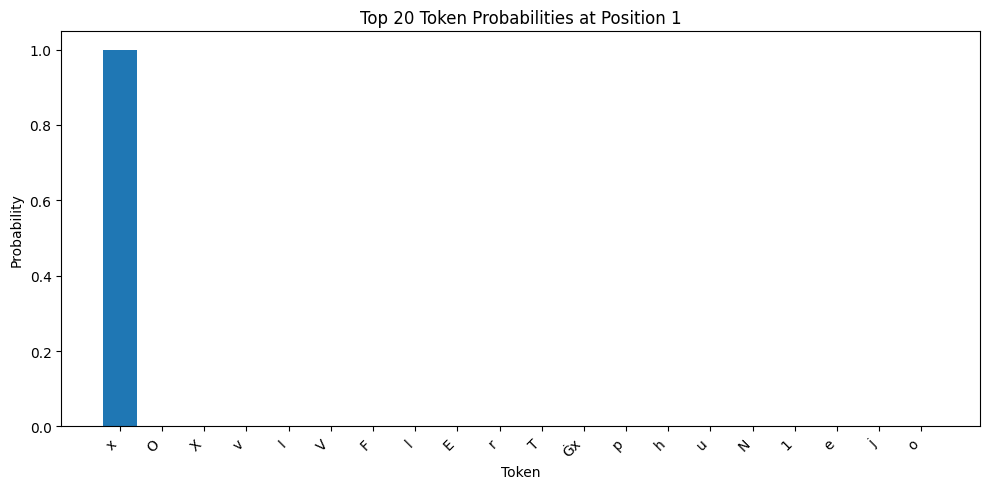

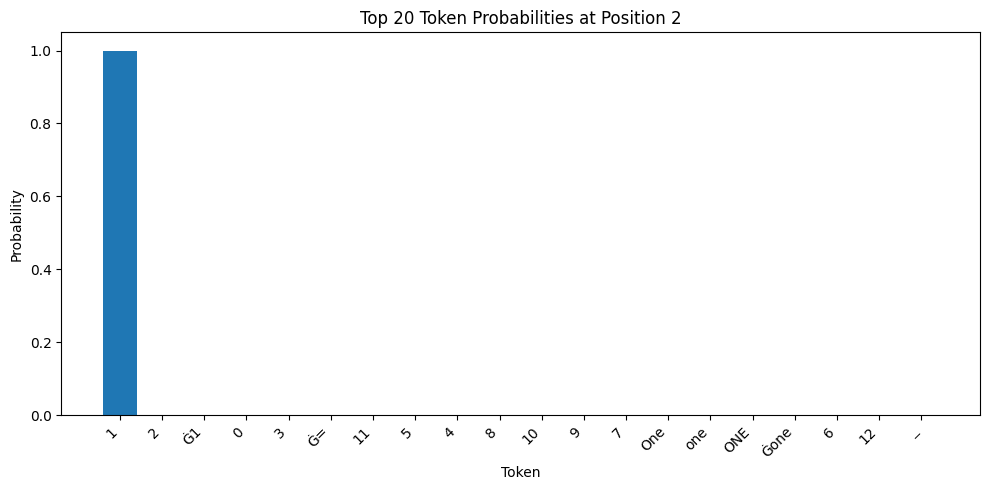

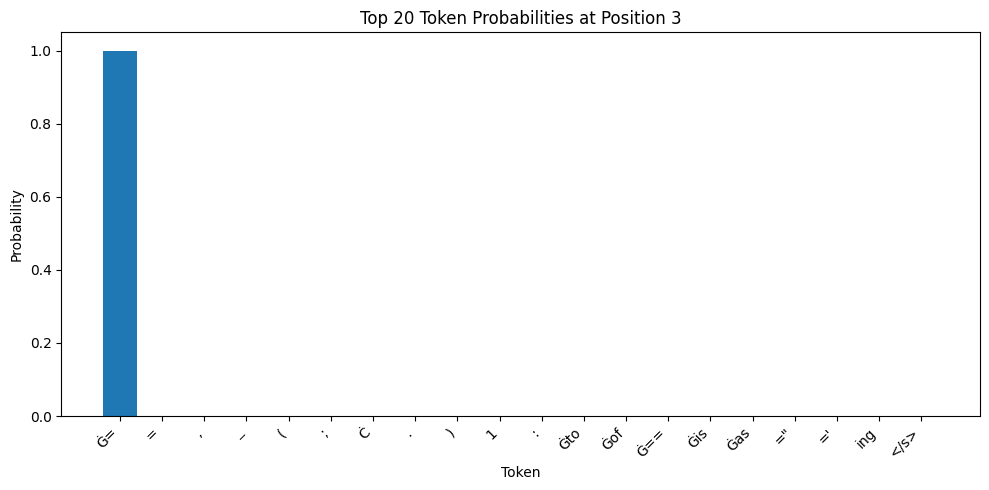

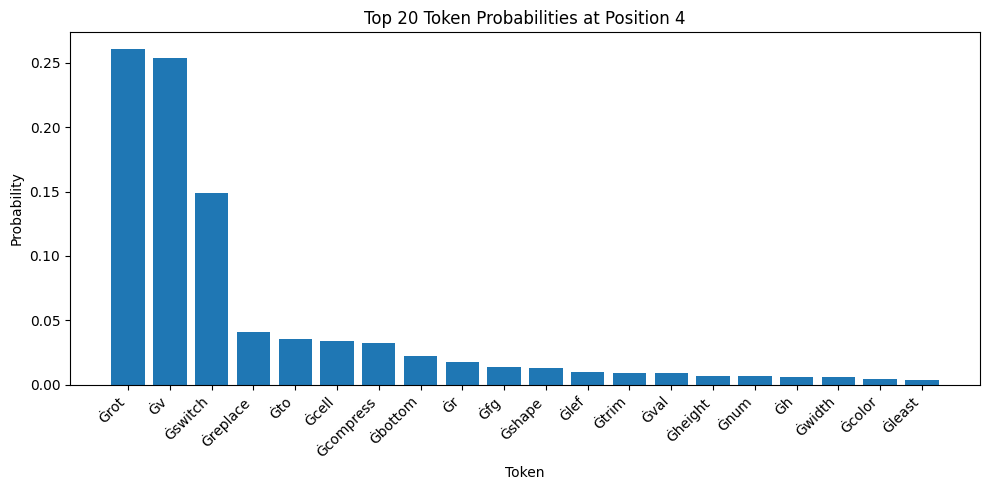

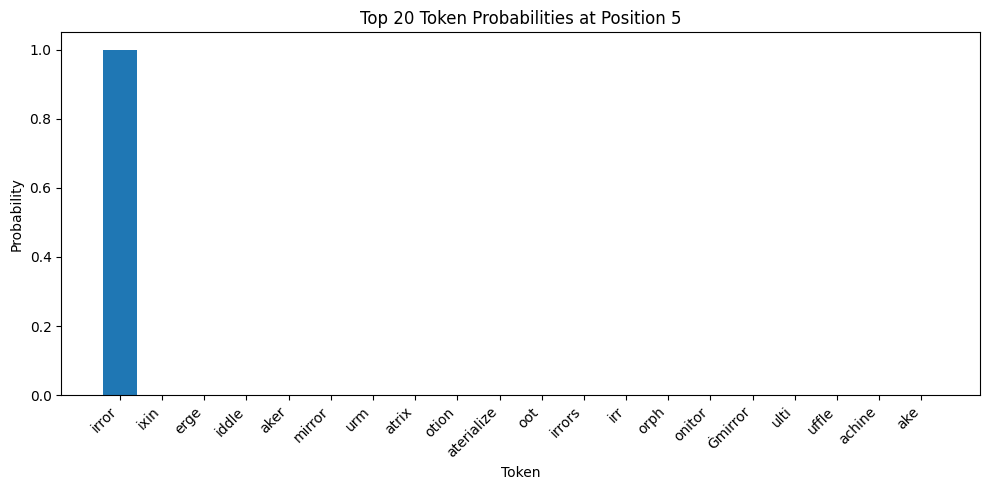

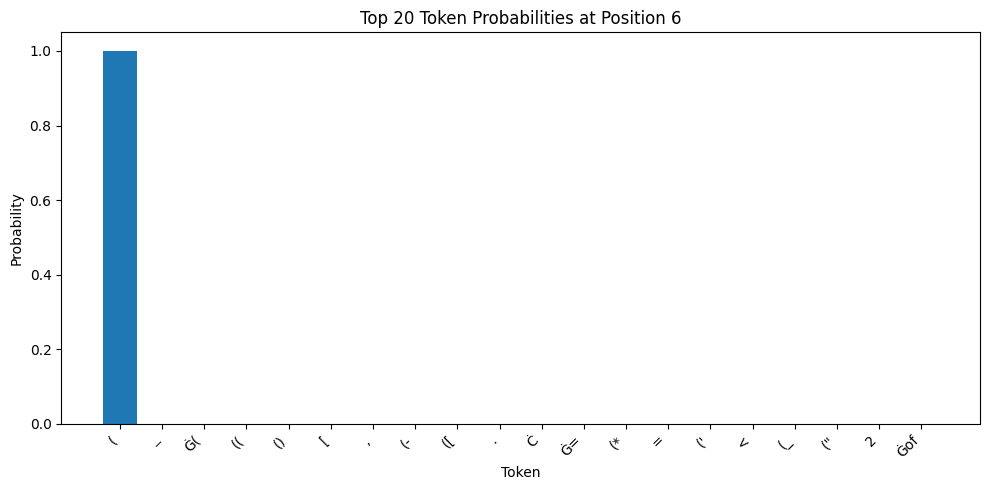

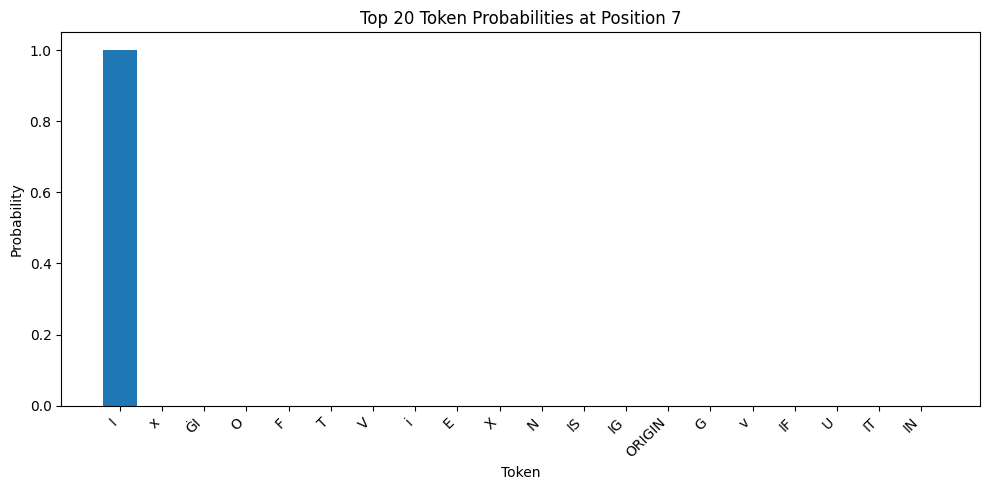

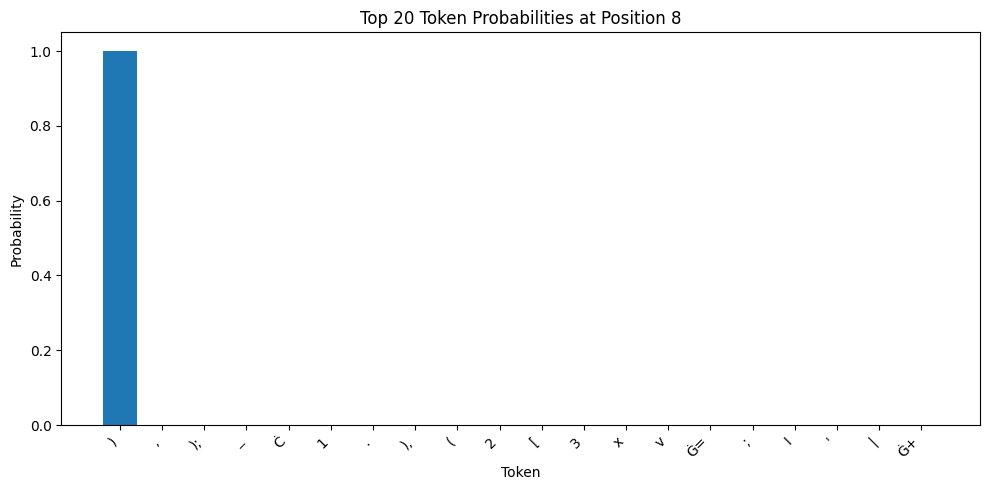

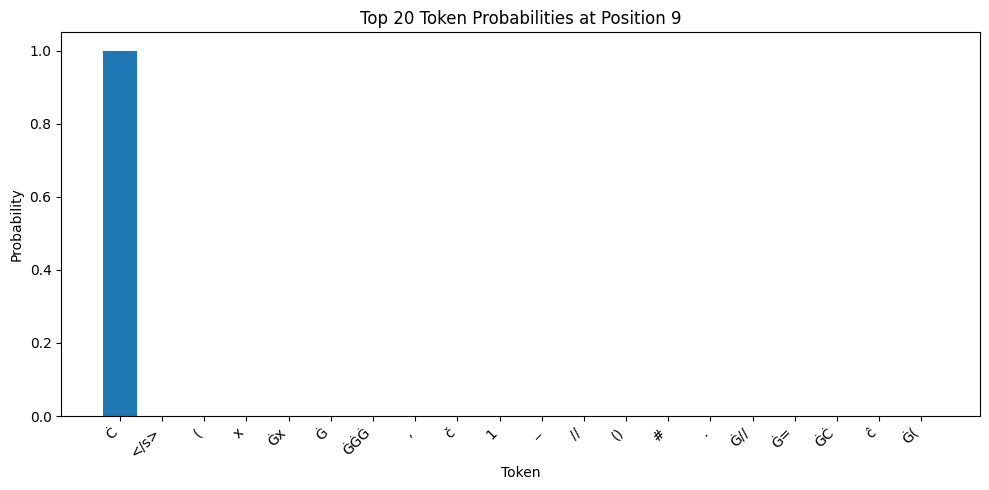

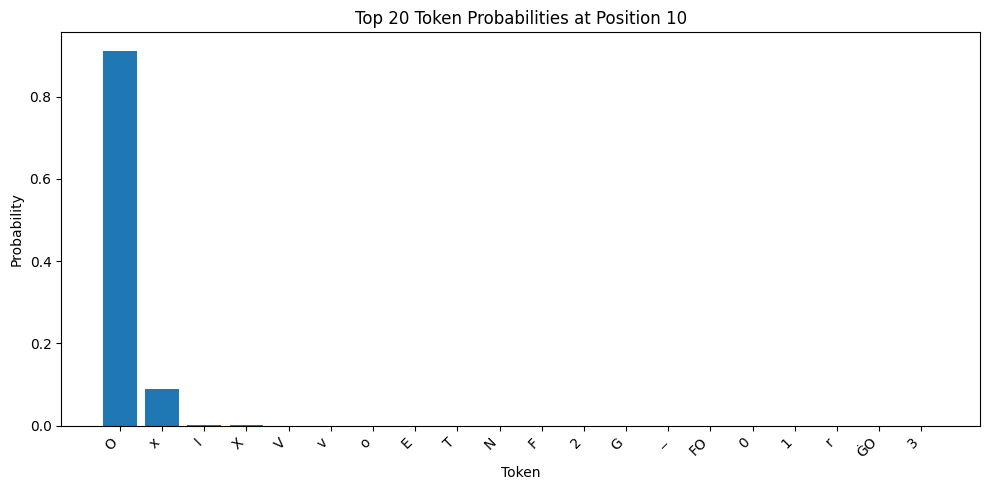

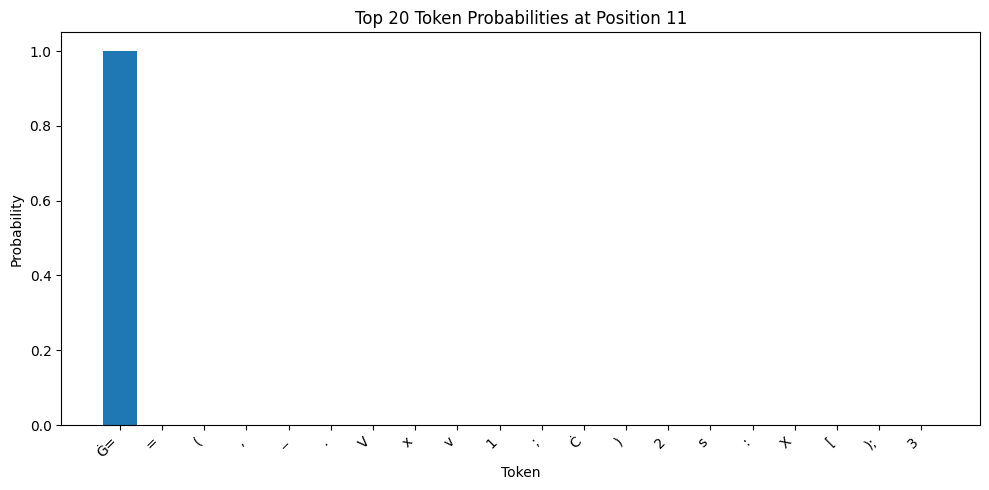

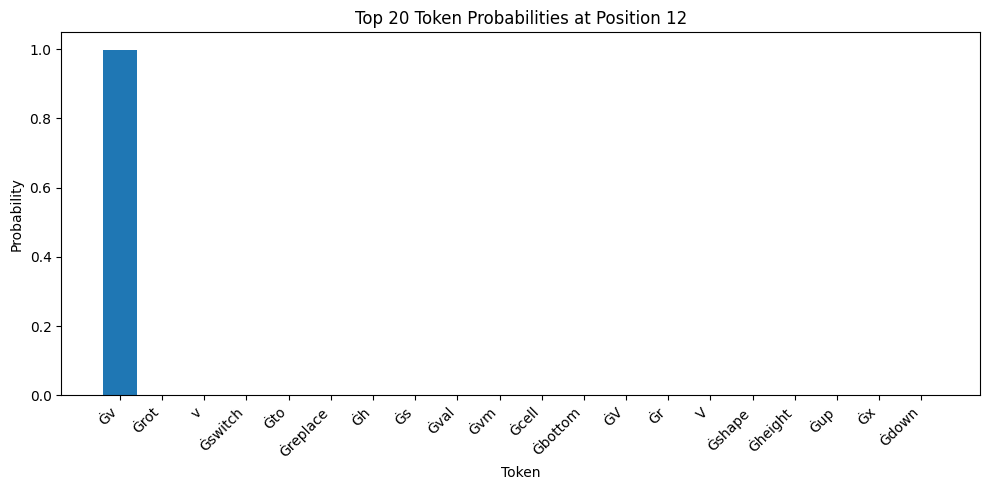

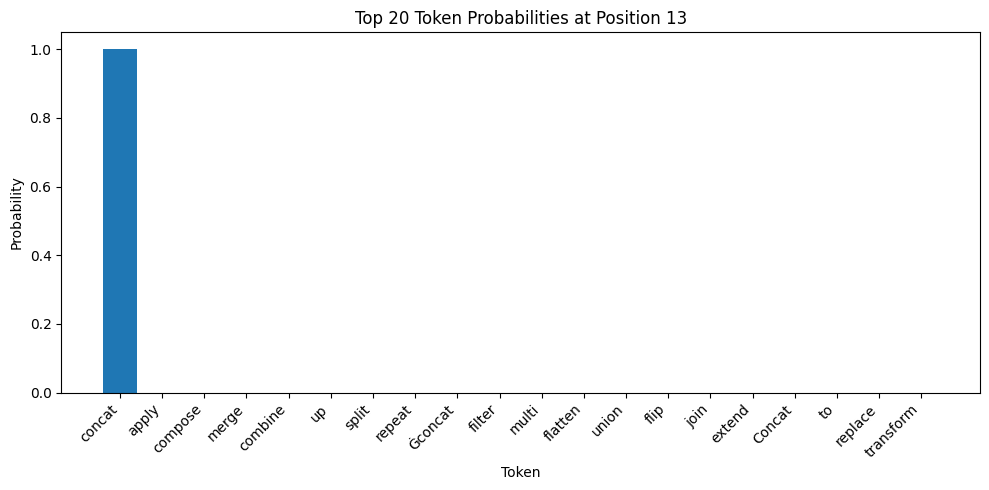

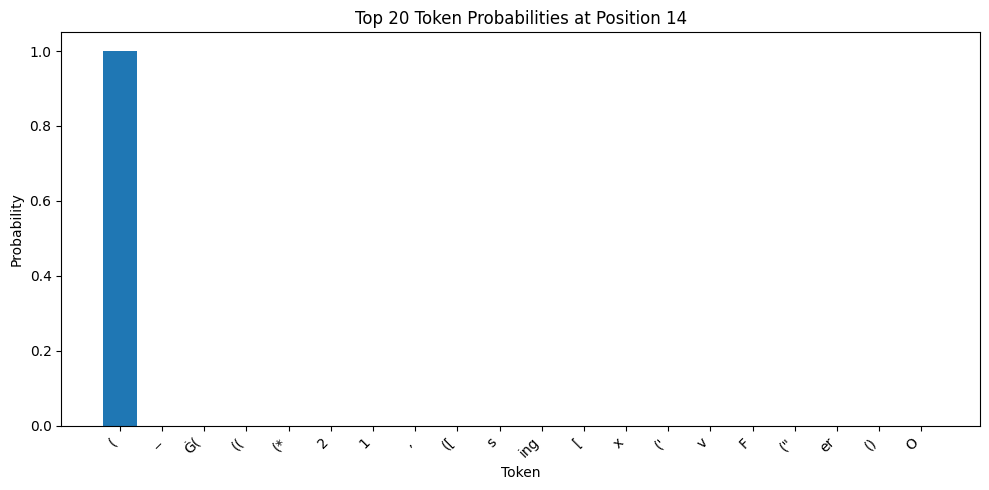

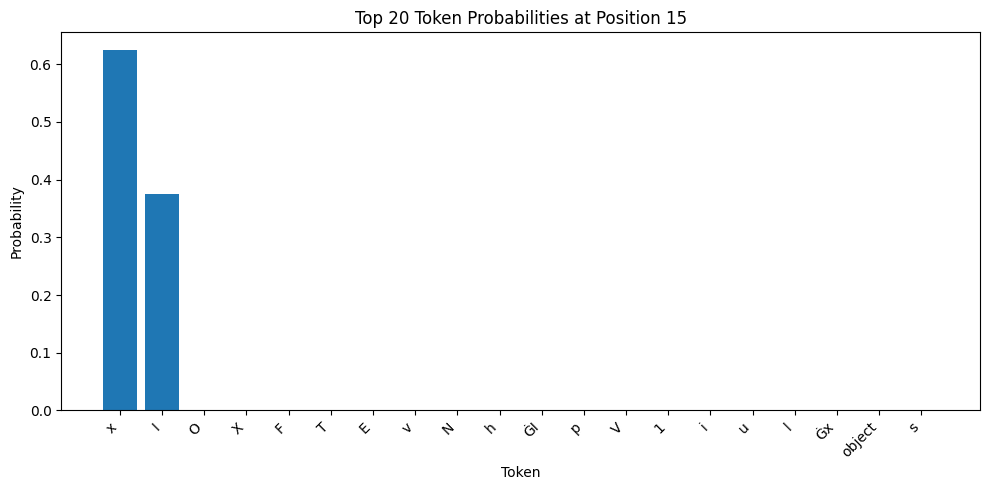

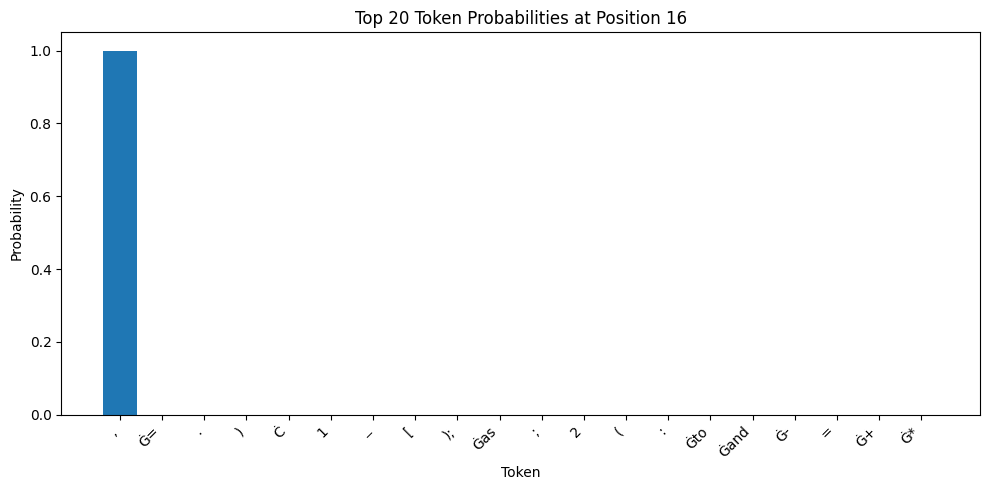

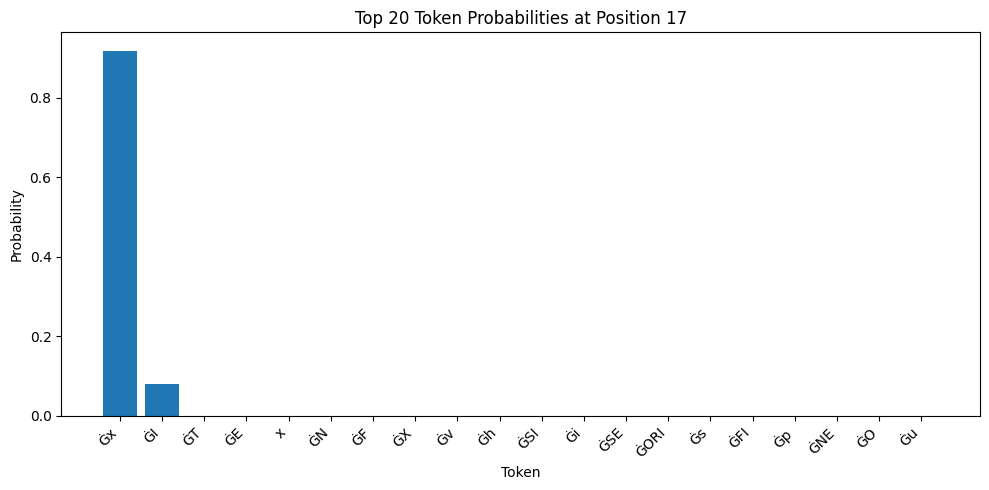

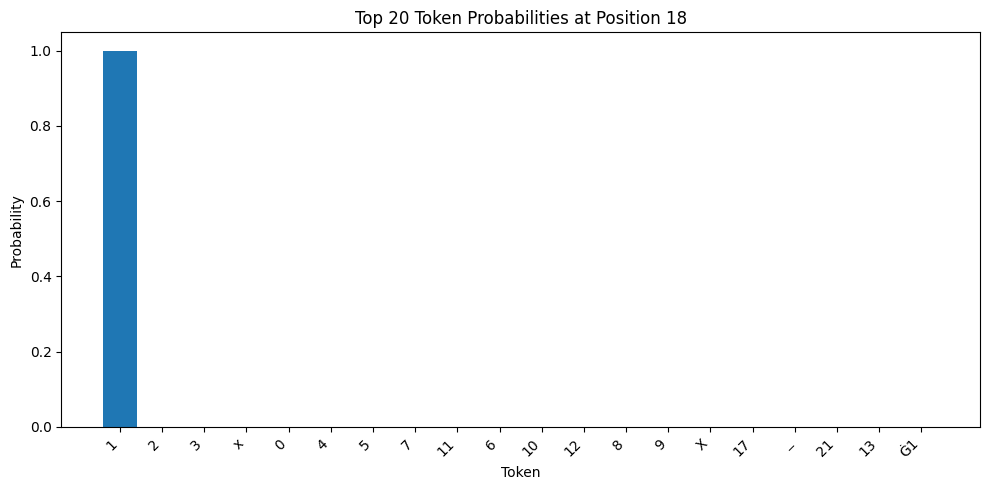

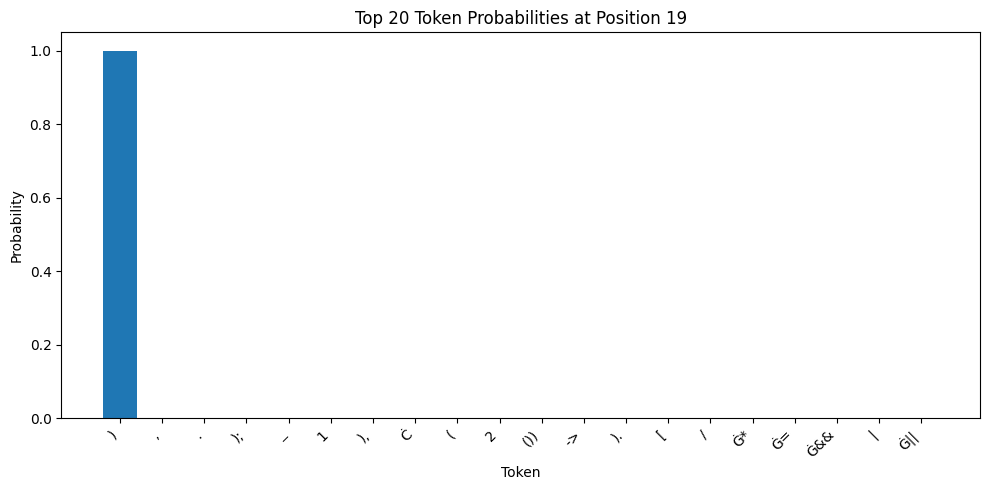

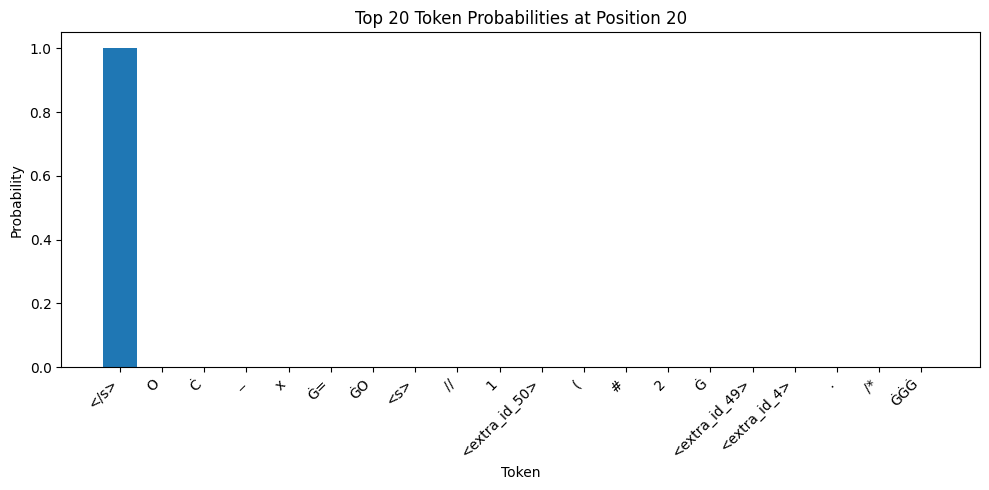

In [91]:

def token_stats(logits, ids):
    log_p = torch.log_softmax(logits, -1)           # [1, L, V]
    probs = log_p.exp()

    entropy = -(probs * log_p).sum(-1).squeeze(0)   # [L]  (nats)

    # top-1 correctness
    top1_ids = logits.argmax(-1)                    # [1, L]
    is_correct = (top1_ids == ids).float().squeeze(0)

    p_true = probs.gather(2, ids.unsqueeze(-1)).squeeze(0).squeeze(-1)

    return entropy.cpu(), is_correct.cpu(), p_true.cpu()




def compute_logits(task, model, ): 
    tok      = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')
    target_text = task.program_lines
    model.eval()

    # teacher-forcing forward pass
    input_   = torch.tensor(encode_task(task, tok, model)).unsqueeze(0)

    ids      = tok(target_text, return_tensors="pt").input_ids

    with torch.no_grad():
        logits = model(input_, labels =ids).logits        # [1, seq_len, vocab]
    
    log_p     = torch.log_softmax(logits, -1)

    token_logp = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)  
    p_token    = token_logp.exp().squeeze().tolist()            
    tokens     = tok.convert_ids_to_tokens(ids[0])

    return logits, ids

def visualize_topk_probs(logits, position, tokenizer, k=20, temperature=1):
   
    # Extract logits for the given position
    logits_at_pos = logits[0, position]  # [vocab_size]

    
    probs = torch.softmax(logits_at_pos / temperature, dim=-1)
    # Get top-k
    topk_probs, topk_indices = torch.topk(probs, k)
    topk_tokens = tokenizer.convert_ids_to_tokens(topk_indices.tolist())

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(k), topk_probs.detach().numpy())
    plt.xticks(range(k), topk_tokens, rotation=45, ha='right')
    plt.xlabel("Token")
    plt.ylabel("Probability")
    plt.title(f"Top {k} Token Probabilities at Position {position}")
    plt.tight_layout()
    plt.show()





logits, ids= compute_logits( task, model)
entropy, is_correct, p_true = token_stats(logits, ids )
tok      = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')


for i in range(logits.shape[1]):
    visualize_topk_probs(logits,i, tok )
